# Project Analysis
### Sam Andrews, Dom Bouchard, John Logsdon
### 05/09/25

In [545]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [547]:
#load in cleaned/scraped csv file
df = pd.read_csv('integrated_dataset.csv')
df

,School,CONF,G,W,ADJOE,ADJDE,BARTHAG,EFG_O,EFG_D,TOR,...,3P_O,3P_D,ADJ_T,WAB,POSTSEASON,SEED,YEAR,Type,City,State
0,North Carolina,ACC,40,33,123.3,94.9,0.9531,52.6,48.1,15.4,...,32.7,36.2,71.7,8.6,2ND,1.0,2016,Public,Chapel Hill,North Carolina
1,North Carolina,ACC,39,33,121.0,91.5,0.9615,51.7,48.1,16.2,...,35.5,33.9,72.8,8.4,Champions,1.0,2017,Public,Chapel Hill,North Carolina
2,North Carolina,ACC,37,26,120.7,97.1,0.9242,52.0,50.1,16.7,...,35.9,38.0,72.6,7.1,R32,2.0,2018,Public,Chapel Hill,North Carolina
3,North Carolina,ACC,34,24,113.4,94.7,0.8883,49.9,47.0,16.9,...,33.6,31.7,70.8,4.2,R32,6.0,2014,Public,Chapel Hill,North Carolina
4,North Carolina,ACC,35,24,111.6,93.0,0.8902,49.3,48.0,17.2,...,37.2,34.4,71.4,2.5,R32,8.0,2013,Public,Chapel Hill,North Carolina
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3832,Texas A&M Commerce,Slnd,30,13,94.3,111.4,0.1281,46.0,52.4,16.7,...,29.4,35.0,66.1,-13.9,NaN,NaN,2024,Public,Commerce,Texas
3833,Stonehill,NEC,30,14,94.4,107.6,0.1809,50.9,50.2,19.7,...,34.8,34.6,66.6,-12.6,NaN,NaN,2023,Private,Easton,Massachusetts
3834,Stonehill,NEC,30,4,90.3,114.2,0.0629,46.7,52.7,19.5,...,30.1,35.9,68.1,-22.0,NaN,NaN,2024,Private,Easton,Massachusetts
3835,Queens,ASun,30,18,105.7,108.3,0.4299,51.2,53.0,17.6,...,34.8,35.3,69.8,-9.4,NaN,NaN,2023,Private,Charlotte,North Carolina


# Analysis Question 1
- How have scoring/offensive trends evolved over the last decade?

### Trend Visualization
- line plot visualizing 2pt vs 3pt rate grouping by year

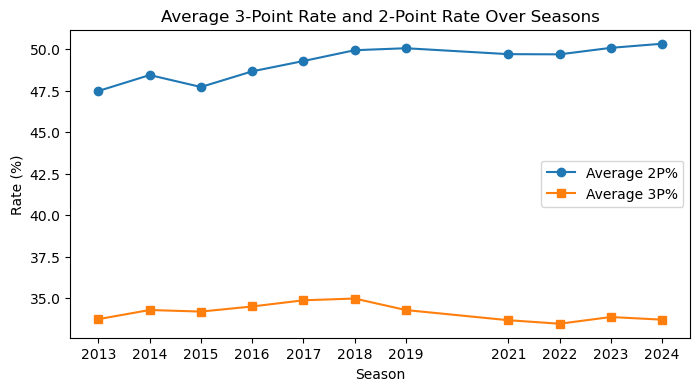

In [554]:
avg_rates = df.groupby('YEAR')[['3P_O', '2P_O']].mean()

plt.figure(figsize=(8,4))
plt.plot(avg_rates.index, avg_rates['2P_O'], marker='o', label='Average 2P%')
plt.plot(avg_rates.index, avg_rates['3P_O'], marker='s', label='Average 3P%')
plt.title('Average 3‑Point Rate and 2‑Point Rate Over Seasons')
plt.xlabel('Season')
plt.ylabel('Rate (%)')
plt.xticks(avg_rates.index)
plt.legend()
plt.savefig('Q1 - 3P_0 and 2P_O over seasons.png')

plt.show()

### Machine Learning
- use LinearRegression() to predict ADJOE with the variables pace, field goal %, turnover rate, offensive rebounding, free throw rate, 3pt rate, and year

In [478]:
features = ['ADJ_T', 'EFG_O', 'TOR', 'ORB', 'FTR', 'YEAR']
X = df[features]
y = df['ADJOE']

In [480]:
#machine learning methods using 80/20 split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

models = {
    "Linear Regression": LinearRegression(),
    "Lasso Regression": Lasso(),
    "KNN": KNeighborsRegressor(n_neighbors=5),
    'Decision Tree' : DecisionTreeRegressor(random_state=42)}

In [482]:
# use for loop to go through each model and score
results = []
for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    results.append({
        'Model': name,
        'MSE': mse(y_test, preds),
        'MAE': mae(y_test, preds),
        'R2': r2_score(y_test, preds)
    })

In [484]:
results_df = pd.DataFrame(results).sort_values('R2', ascending=False).reset_index(drop=True)
display(results_df)

,Model,MSE,MAE,R2
0,Linear Regression,9.368956,2.490337,0.829273
1,Lasso Regression,9.847580,2.555351,0.820551
2,KNN,13.883684,2.996354,0.747002
3,Decision Tree,22.634414,3.712630,0.587540


#### Linear Regression exhibits the highest accuracy (r^2) out of the 4 machine learning methods

In [515]:
linreg = models['Linear Regression']
print(f'Model Intercept: {linreg.intercept_}')
coef = pd.Series(linreg.coef_, index = features)
print(f'\nModel Coefficients:')
print(coef)

Model Intercept: -41.82693143518294

Model Coefficients:
ADJ_T   -0.029559
EFG_O    1.465450
TOR     -1.512462
ORB      0.690982
FTR      0.115377
YEAR     0.038569
dtype: float64


### Time Series Forecasting
- Holt-Winters method (additive)
  

In [533]:
# add 'Year' columns using pd.to_datetime and set frequency to annual
df['Year'] = pd.to_datetime(df['YEAR'], format = '%Y')
yearly_off = df.groupby(df['Year'])['ADJOE'].mean()
yearly_off = yearly_off.asfreq('AS')
yearly_off

Year
2013-01-01    100.966569
2014-01-01    104.682029
2015-01-01    102.390145
2016-01-01    103.901739
2017-01-01    103.906052
2018-01-01    104.410663
2019-01-01    103.397135
2020-01-01           NaN
2021-01-01    102.014577
2022-01-01    102.307022
2023-01-01    104.191111
2024-01-01    105.247075
Freq: AS-JAN, Name: ADJOE, dtype: float64

In [535]:
# interpolate 2020 to use the middle ground between 2019 and 2021
yearly_off = yearly_off.reindex().interpolate(method = 'linear')
yearly_off

Year
2013-01-01    100.966569
2014-01-01    104.682029
2015-01-01    102.390145
2016-01-01    103.901739
2017-01-01    103.906052
2018-01-01    104.410663
2019-01-01    103.397135
2020-01-01    102.705856
2021-01-01    102.014577
2022-01-01    102.307022
2023-01-01    104.191111
2024-01-01    105.247075
Freq: AS-JAN, Name: ADJOE, dtype: float64

In [537]:
# Holt-Winters method
hw_model = ExponentialSmoothing(yearly_off, trend = 'add', seasonal = None)
hw_fit = hw_model.fit()

In [539]:
# set to a 10 yr forecast
horizon = 10
forecast = hw_fit.forecast(horizon)
forecast

2025-01-01    103.980500
2026-01-01    104.078526
2027-01-01    104.176552
2028-01-01    104.274579
2029-01-01    104.372605
2030-01-01    104.470631
2031-01-01    104.568657
2032-01-01    104.666684
2033-01-01    104.764710
2034-01-01    104.862736
Freq: AS-JAN, dtype: float64

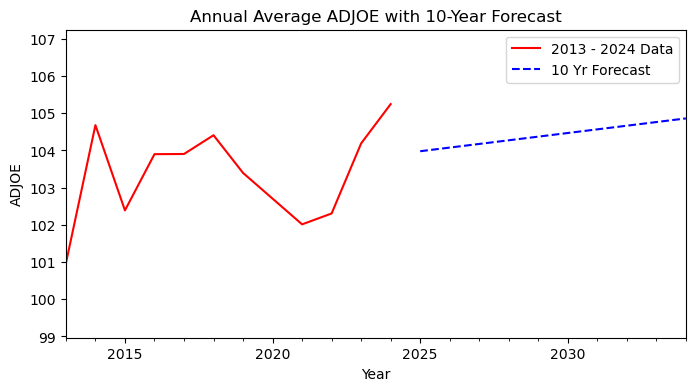

In [558]:
plt.figure(figsize = (8,4))

lower = yearly_off.min() - 2
upper = yearly_off.max()+ 2
plt.ylim(lower,upper)

yearly_off.plot(label = '2013 - 2024 Data', color = 'red')
forecast.plot(label=f'10 Yr Forecast', linestyle='--', color = 'blue')
plt.title('Annual Average ADJOE with 10-Year Forecast')
plt.xlabel('Year')
plt.ylabel('ADJOE')
plt.legend()
plt.savefig('Q1 - HW 10 Yr Forecast (ADJOE).png')

plt.show()